# L665 ML for NLPSpring 2018 

## Assignment 1 - Task 4, notebook 2 of 3 
### fastTask implementation with Keras per article by Joulan, Armand, et al. "Bag of tricks for efficient text classification." arXiv preprint arXiv:1607.01759 (2016)


**My code is modeled after: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py** <br>
**With  tips from: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/** <br>

Author: Carlos Sathler

In [1]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


## Read Data

In [2]:
df_all = pd.read_csv('input/train.csv')
drop_cols = ['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_all = df_all.drop(drop_cols, axis=1)
df_all = df_all.sample(frac=0.2)
df_all.head()
y_all = df_all.values[:,-1].reshape(-1,1)

In [3]:
# normalize text
import re
pat = re.compile(u'[^a-zA-Z0-9]')
def normalize(txt):
    return pat.sub(' ',txt)
    
df_all['comment_text'] = df_all['comment_text'].apply(lambda x: normalize(x)) 

## Define fastText NN model

In [4]:
def get_fastText_model(voc_size, seq_len, out_dim):
    model = Sequential()
    # first layer is for sequence of word embeddings that the model will train during classification task
    model.add(Embedding(voc_size, out_dim, input_length=seq_len))
    # second layer averages word embeddings in comment into a single variable
    # this will create the "hidden variable" mentioned by Joulin et. al.
    model.add(GlobalAveragePooling1D())
    # use perceptron node with sigmoid activation since this is a single class problem
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

## Create embeddings for words and create sequence of embeddings for each comment

In [5]:
%%time
VOC_SIZE=10000
SEQ_LEN=500
EMBEDDING_DIM=300
EPOCHS=30

X_all = df_all.comment_text.values

# use Keras tokenizer to create sequences of word embeddings
t = Tokenizer(num_words=VOC_SIZE)
t.fit_on_texts(X_all)
X_all_seqs = t.texts_to_sequences(X_all)

# make all sequences the same length (we don't worry about how big each row is)
X_all_seqs = pad_sequences(X_all_seqs, maxlen=SEQ_LEN, dtype='int32', padding='pre', truncating='pre')

#print(X_all[1], '\n', X_all_seqs[1])

CPU times: user 3.67 s, sys: 120 ms, total: 3.79 s
Wall time: 3.79 s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 3,000,301
Trainable params: 3,000,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 14325 samples, validate on 7057 samples
Epoch 1/30
 - 19s - loss: 0.3260 - acc: 0.9065 - val_loss: 0.3098 - val_acc: 0.9001
Epoch 2/30
 - 18s - loss: 0.2869 - acc: 0.9070 - val_loss: 0.2933 - val_acc: 0.9005
Epoch 3/30
 - 19s - loss: 0.2659 - acc: 0.9079 - val_loss: 0.2750 - val_acc: 0.9015
Epoch 4/30
 - 18s - loss: 0.2377 - acc: 0.9096 - val_loss: 0.2527 - val_acc: 0.9031
Epoch 

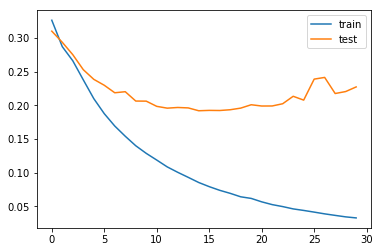

CPU times: user 38min 15s, sys: 4min 13s, total: 42min 29s
Wall time: 9min 25s


In [6]:
%%time

# partition data
X_train, X_test, y_train, y_test = train_test_split(X_all_seqs, y_all, test_size=0.33)
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.33)

model = get_fastText_model(VOC_SIZE, SEQ_LEN, EMBEDDING_DIM)
# define optimizer, loss and metric for learning
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train the model
history = model.fit(X_t, y_t, batch_size=32, epochs=EPOCHS, validation_data=(X_v, y_v), verbose=2)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [7]:
y_hat = model.predict(X_test)
y_hat = np.round(y_hat,1).astype('int')
acc = accuracy_score(y_test.astype('int'), y_hat)
print("Accuracy = {}".format(acc))

Accuracy = 0.9377136346372958
